# Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Import Data_DIR , Work_DIR

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

pathdata = "gdrive/My Drive/lstm/lstm_data"
pathwork = "gdrive/My Drive/lstm/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
BASE_DIR = pathdata
WORKING_DIR = pathwork

# Extract Image Features

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# extract features from image

In [5]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir('/content/gdrive/MyDrive/lstm/lstm_data/Images')):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/300 [00:00<?, ?it/s]

# store features in pickle

In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the Captions Data

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/74990 [00:00<?, ?it/s]

In [10]:
len(mapping)

300

# Preprocess Text Data

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['advice-dog']

['"hiTLER WASNT SUCH A BAD GUY AFTER ALL  HE DID KILL HITLER"',
 'its only racist If your white',
 'be first get stuck in demigod tier',
 'Save planet turn on air conditioning',
 'didnt get what you want? shit on the floor',
 '"get pinnochio to say ""my nose will now grow"" laugh as reality explodes"',
 'Become a dog lick your genitals all day',
 'Want to burn some calories light a fat kid on fire',
 'A cigarette a day keeps the doctor away',
 '"Im so lucky in 10-12 years  I get to move to a farm in the country"',
 'bomb japan wipe out 90% of worlds necrophiliac population',
 'break open a beehive free honey',
 'Stuck in a awkward situation Racist',
 'SeLL Drugs Become a Rapper',
 '"what do you mean by: ""get off the mailman"" ?"',
 '"i could maybe ""take you there"" if you put peanut butter on your hoo hoo"',
 'cOVER pRIVATE aREA IN hONEY UNLEASH THE BEES!',
 'broke something? blame me',
 'WANT FUN? SLAP CHUCK NORRIS!',
 'like her? hump her leg',
 'GRASSS!! rolls in grace',
 'Dont wan

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['advice-dog']

['startseq "hitler wasnt such bad guy after all he did kill hitler" endseq',
 'startseq its only racist if your white endseq',
 'startseq be first get stuck in demigod tier endseq',
 'startseq save planet turn on air conditioning endseq',
 'startseq didnt get what you want? shit on the floor endseq',
 'startseq "get pinnochio to say ""my nose will now grow"" laugh as reality explodes" endseq',
 'startseq become dog lick your genitals all day endseq',
 'startseq want to burn some calories light fat kid on fire endseq',
 'startseq cigarette day keeps the doctor away endseq',
 'startseq "im so lucky in 10-12 years get to move to farm in the country" endseq',
 'startseq bomb japan wipe out 90% of worlds necrophiliac population endseq',
 'startseq break open beehive free honey endseq',
 'startseq stuck in awkward situation racist endseq',
 'startseq sell drugs become rapper endseq',
 'startseq "what do you mean by: ""get off the mailman"" ?" endseq',
 'startseq "i could maybe ""take you the

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

74989

In [17]:
all_captions[:10]

['startseq commercial no same volume as show!? endseq',
 'startseq ted no tell us how you met their mother endseq',
 'startseq internet no let me study endseq',
 'startseq bad grades no smoke weed and get high? endseq',
 'startseq green land no green? endseq',
 'startseq users no upvote? endseq',
 'startseq support guy no give me ammo endseq',
 'startseq said glass of juice! not gas the jews! endseq',
 'startseq classmates no return pens borrow you endseq',
 'startseq god why no give us extra lives? endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

49940

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

25

# Train Test Split

In [25]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [26]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [27]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

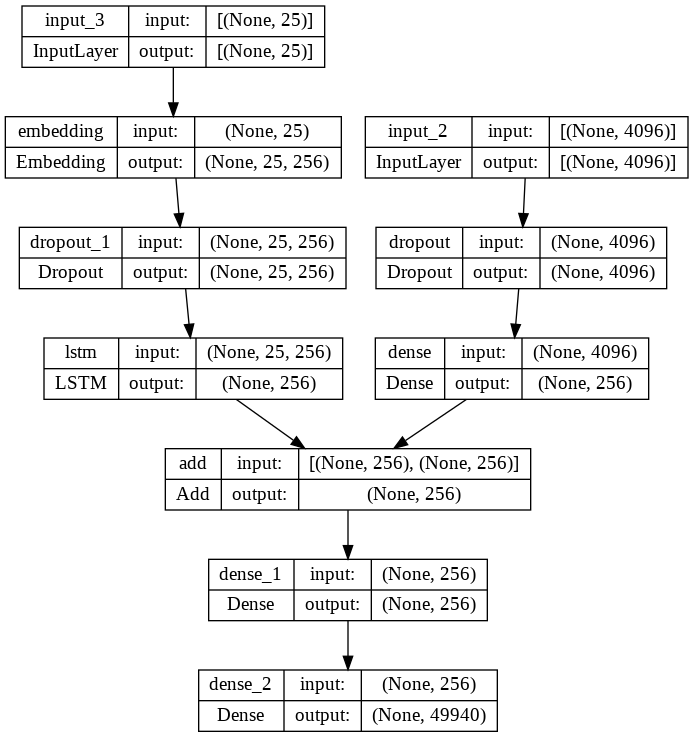

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 12
batch_size = 5
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

54/54 [==============================] - 172s 3s/step - loss: 5.5865


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model2.h5')

# Generate Captions for the Image

In [21]:
import numpy as np
from tensorflow import keras

model = keras.models.load_model(WORKING_DIR+'/best_model2.h5')

In [22]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [23]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/30 [00:00<?, ?it/s]

BLEU-1: 0.305263
BLEU-2: 0.192466


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

# Generate Meme for New Image

In [30]:
import re
from copy import deepcopy

PUNCT_PATTERN = re.compile(r"( )([!#$%&\()*+,\-.\/:;<=>?@\\^{|}~]+)")
SPECIAL_TOKENS = {
    'PAD': '<pad>',
    'UNK': '<unk>',
    'BOS': '<bos>',
    'EOS': '<eos>',
    'SEP': '<sep>',
    'EMPTY': '<emp>',
}

def split_caption(text, num_blocks=None):
    """Splits text caption into blocks according to the special tokens.

    Args:
        text (str): input caption text
        num_blocks (int): number of blocks to return (`None` for keeping all)

    Returns:
        List[str]: a list of text blocks
    """

    def _clean_text_block(text_block):
        text_block = re.sub(r'<\w+>', '', text_block)
        text_block = re.sub(r'^\s+', '', text_block)
        text_block = re.sub(r'\s+$', '', text_block)
        text_block = PUNCT_PATTERN.sub('\\2', text_block)
        return text_block

    text_blocks = text.split(SPECIAL_TOKENS['SEP'])

    # clean blocks from any special tokens and padding spaces
    text_blocks = [_clean_text_block(t) for t in text_blocks]

    if num_blocks is None:
        num_blocks = len(text_blocks)
    elif len(text_blocks) < num_blocks:
        text_blocks += [''] * (num_blocks - len(text_blocks))

    return text_blocks[:num_blocks]

In [31]:
MEME_FONT_PATH = WORKING_DIR+'/impact.ttf'

from PIL import ImageFont, ImageDraw

def get_maximal_font(img, text, font_size=64, text_width=0.94, font_path=MEME_FONT_PATH):
    """Computes the font of maximal size that fits the text.

    Args:
        img (PIL.Image): input image
        text (str): text to fit into image
        font_size (int): initial font size
        text_width (float): text width ratio with respect to image width
        font_path (str): path to font

    Returns:
        PIL.ImageFont: optimal font
    """
    font = ImageFont.truetype(font_path, font_size)
    w, h = font.getsize(text)

    # find the biggest font size that works
    while w > img.width * text_width:
        font_size = font_size - 1
        font = ImageFont.truetype(font_path, font_size)
        w, h = font.getsize(text)

    return font

def _get_initial_font(img, texts, max_chars=20, font_path=MEME_FONT_PATH):
    """Compute initial font of maximal size based of texts.

    Args:
        img (PIL.Image): input image
        texts (List[str]): list of texts
        max_chars (int): maximum number of characters in a line
        font_path (str): path to font

    Returns:
        PIL.ImageFont: optimal font
    """
    # compute the maximum number of characters in a line
    max_len = max(map(len, texts))
    max_len = max_len if max_len < max_chars else max_chars
    longest_text = 'G' * max_len

    # get initial font size from image dimensions
    font_size = int(img.height / 5.4)

    # get maximal font for the initial text
    font = get_maximal_font(img, longest_text, font_size, font_path=font_path)

    return font

def _get_final_font(img, text_lines, font_path=MEME_FONT_PATH):
    """Compute final font of maximal size based of texts split into lines.

    Args:
        img (PIL.Image): input image
        text_lines (List[List[str]]): list of list of text lines
        font_path (str): path to font

    Returns:
        PIL.ImageFont: optimal font
    """
    # initial font size
    font_size = int(img.height / 5.4) // max(map(len, text_lines))
    font = ImageFont.truetype(font_path, font_size)

    # find the text with the highest occupied width
    text_lines = [text for lines in text_lines for text in lines]
    lengths = list(map(lambda x: font.getsize(x)[0], text_lines))
    longest_text = text_lines[np.argmax(lengths)]

    # get maximal font for the text with highest width
    font = get_maximal_font(img, longest_text, font_size, font_path=font_path)

    return font

def split_to_lines(img, text, font):
    """Splits text into lines to fit the image with a given font.

    Args:
        img (PIL.Image): input image
        text (str): input text
        font (PIL.ImageFont): text font

    Returns:
        List[str]: list of text lines
    """
    draw = ImageDraw.Draw(img)
    text = text.replace('', '').upper()
    w, h = draw.textsize(text, font)  # measure the size the text will take

    # compute the number of lines
    line_count = 1
    if w > img.width:
        line_count = w // img.width + 1

    lines = []
    if line_count > 1:
        # cut text into lines preserving words

        last_cut = 0
        is_last = False

        for i in range(0, line_count):
            cut = (len(text) // line_count) * i if last_cut == 0 else last_cut

            if i < line_count - 1:
                next_cut = (len(text) // line_count) * (i + 1)
            else:
                next_cut = len(text)
                is_last = True

            # make sure we don't cut words in half
            if not (next_cut == len(text) or text[next_cut] == " "):
                while text[next_cut] != " ":
                    next_cut += 1

            line = text[cut:next_cut].strip()

            # does line still fit?
            w, h = draw.textsize(line, font)
            if not is_last and w > img.width * 0.95:
                next_cut -= 1
                while text[next_cut] != " ":
                    next_cut -= 1

            last_cut = next_cut
            lines.append(text[cut:next_cut].strip())
    else:
        lines.append(text)

    return lines

def caption_image(img, text_lines, font, pos='top'):
    """Captions the image with text.

    Args:
        img (PIL.Image): input image
        text_lines (List[str]): list of text lines
        font (PIL.ImageFont): text font
        pos (str): position of text (`top` or `bottom`)

    Returns:
        PIL.Image: captioned image
    """
    draw = ImageDraw.Draw(img)
    w, h = draw.textsize(text_lines[0], font)  # measure the size the text will take

    # text border size
    border_size = font.size // 18

    # compute the position of text on y-axis
    last_y = -h
    if pos == 'bottom':
        last_y = img.height * 0.987 - h * (len(text_lines) + 1) - border_size

    # draw text lines
    for line in text_lines:
        w, h = draw.textsize(line, font)
        x = img.width / 2 - w / 2
        y = last_y + h

        # add borders of black color
        for xx in range(-border_size, border_size + 1):
            for yy in range(-border_size, border_size + 1):
                draw.text((x + xx, y + yy), line, (0, 0, 0), font=font)

        # add text in white
        draw.text((x, y), line, (255, 255, 255), font=font)

        last_y = y

    return img

def memeify_image(img, top='', bottom='', font_path=MEME_FONT_PATH):
    """Adds top and bottom captions to an image.

    Args:
        img (PIL.Image): input image
        top (str): top caption text
        bottom (str): top caption text
        font_path (str): path to font

    Returns:
        PIL.Image: captioned image
    """
    # do not change existing image
    img = deepcopy(img)

    # initial font
    font = _get_initial_font(img, texts=[top, bottom], font_path=font_path)

    # split texts into lines
    top_lines = split_to_lines(img, top, font)
    bottom_lines = split_to_lines(img, bottom, font)

    # adjust the font
    font = _get_final_font(img, [top_lines, bottom_lines], font_path=font_path)

    # caption image with both texts
    img = caption_image(img, top_lines, font, 'top')
    img = caption_image(img, bottom_lines, font, 'bottom')

    return img

In [32]:
# load vgg16 model
VGGmodel = VGG16()
# restructure the model
VGGmodel = Model(inputs=VGGmodel.inputs, outputs=VGGmodel.layers[-2].output)

In [33]:
def generate_caption_new(image_name):
    new_features = {}
    img_path = "gdrive/My Drive/lstm/test_image/"+ image_name
    image = load_img(img_path, target_size=(224, 224))

    img = Image.open(img_path)

    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = VGGmodel.predict(image, verbose=0)
    # get image ID
    image_id = image_name.split('.')[0]
    # store feature
    new_features[image_id] = feature

    # store features in pickle
    pickle.dump(new_features, open(os.path.join(WORKING_DIR, 'new_features.pkl'), 'wb'))
    # load features from pickle
    with open(os.path.join(WORKING_DIR, 'new_features.pkl'), 'rb') as f:
      new_features = pickle.load(f)

    y_pred = predict_caption(model, new_features[image_id], tokenizer, max_length)
    y_pred = y_pred.replace("startseq","")
    y_pred = y_pred.replace("endseq","")
    test = y_pred.split()
    test = list(set(test))
    y_pred = " ".join(test)

    top = ''
    bottom = y_pred

    plt.imshow(memeify_image(img, top, bottom))

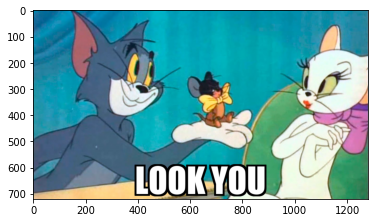

In [34]:
generate_caption_new("tomcat.jpg")

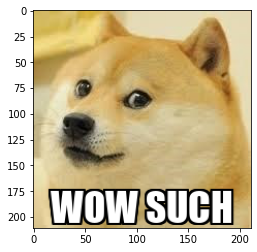

In [35]:
generate_caption_new("dogeee.jpg")

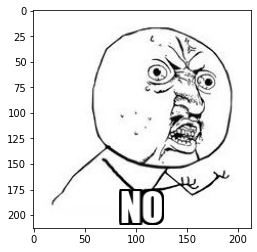

In [36]:
generate_caption_new("y-u-so.jpg")

In [ ]:
generate_caption_new("futurama-fry.jpg")